# 2.1 - Data Preparation
- We typically prepare our data by ingesting it from the source and splitting it into training, validation, and test data splits.

In [1]:
import pandas as pd
# Data ingestion
DATASET_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
df = pd.read_csv(DATASET_LOC)
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


## Splitting the data

1. Use the **train** split to trian the model.
2. After each epoch use the **validation** split to evaluate the model. This is used to optimize the model.
3. After training, use the **test** split to evaluate the model. This is the best measure on how the model will perform on unseen data.

In [2]:
from sklearn.model_selection import train_test_split

#Value Counts
df.tag.value_counts()

tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

## Stratified Sampling
- Since we don't want an imbalance in our data, we want to make sure that the data splits have similar class distributions. 
- We can use the **stratify** keyword argument with the `train_test_split` function from `sklearn.model_selection` to ensure that the splits have similar class distributions.


In [3]:
import random
#split the dataset
random_state=random.seed(1337)
test_size:float=0.2
train_df,val_df=train_test_split(df,stratify=df.tag,test_size=test_size,random_state=random_state)
N_train=1-test_size

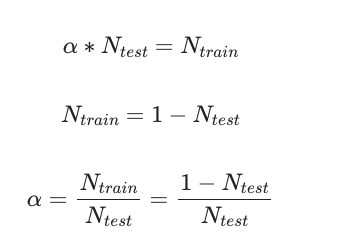

- Due to sampling, we must balance the number of training samples and the number of validation samples.
- The formula is as pictured, so we need to make sure the validation set is 20% of the training set.

In [4]:
train_df.tag.value_counts()

tag
natural-language-processing    248
computer-vision                228
other                           85
mlops                           50
Name: count, dtype: int64

In [5]:
#Validation (adjusted) value counts
val_df.tag.value_counts() * int((1-test_size)/test_size)

tag
natural-language-processing    248
computer-vision                228
other                           84
mlops                           52
Name: count, dtype: int64

# 2.2 Data Exploration

-- EDA (exploratory data analysis) is a method to understand the signals and nuances of our data, and is used in various points of our development process.
- How to think about EDA:
    - not just to visualize a data set
    - goal is to convince yourself that the data you have is sufficient for the task
    - use EDA to answer important questions and to make it easier to extract insight
    - not a one time process, need to revisit EDA to catch distribution shift, anomalies, etc

In [6]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import warnings; warnings.filterwarnings('ignore')
from wordcloud import WordCloud, STOPWORDS

In [7]:
# How many data points do we have per tag?
# We'll use the 'Counter' class to get counts for all the different tags
all_tags=Counter(df.tag)
print(all_tags.most_common())

[('natural-language-processing', 310), ('computer-vision', 285), ('other', 106), ('mlops', 63)]


In [8]:
from plotly.express import bar
tags,tag_counts=zip(*all_tags.most_common())
tag_df=pd.DataFrame({'tags':tags,'tag_counts':tag_counts})
fig=bar(data_frame=tag_df,x='tags',y='tag_counts',title="Tag Distribution",color='tags',labels={'tag_counts':"# of projects"})
fig.layout.showlegend=False
fig.show()

We do have some data imbalance and there are strategies to deal with this such as:
- **oversampling** the less frequent classes and **undersampling** popular classes
- **class weights** in the loss function

## WordCloud

- Is there enough signal in the title and description that's unique to each tag?
    - This is important to verify that our initial hypotheses that the title and description are high quality features for predicting the tags.

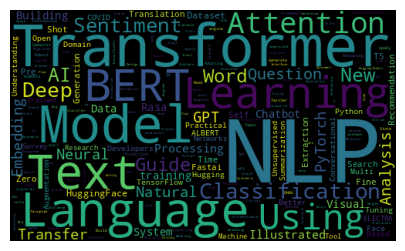

In [9]:
# Most frequent tokens for each tag
tag="natural-language-processing"
plt.figure(figsize=(10, 3))
subset = df[df.tag==tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

# 2.3 Preprocessing
## Feature Engineering Stage


In [10]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

- We can combine existing input features to create new meaningful signal to help the model learn.
- However, there's no way to know if a certain feature combination will help the model learn better, so we have to experiment with different combinations.

In [11]:
df['text']=df.title+' '+df.description

### Cleaning
- Since we're dealing with text, we can apply some basic cleaning to the text.
- This involves regex and natural language toolkit (NLTK)


In [12]:
nltk.download('stopwords')
STOPWORDS=stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marcwolpert/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
def clean_text(text:str,stopwords=STOPWORDS):
  '''clean raw text string'''
  #lower
  text=text.lower()
  
  #remove stopwords
  pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
  text=pattern.sub('',text)
  
  # Spacing and filters
  text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
  text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
  text = re.sub(" +", " ", text)  # remove multiple spaces
  text = text.strip()  # strip white space at the ends
  text = re.sub(r"http\S+", "", text)  #  remove links

  return text

#### Note:
- We could try to include emojis, punctuation, and other special characters in our model, but first we're going to try a simplified version of the data.
- We can always add more features later if we need to.

In [14]:
#apply to df
original_df=df.copy()
df['text']=df['text'].apply(clean_text)
print(f"{original_df['text'].values[0]}\n{df['text'].values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


#### We can wrap up cleaning by:
- removing columns and rows with null tag values

In [15]:
#df cleanup
df=df.drop(columns=['id','created_on','title','description'],errors='ignore')
df=df.dropna(subset=['tag']) #drop nulls
df=df[['text','tag']]
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


#### Encoding
- We need to encode data into numerical values so our models can process them. 
- We can start by encoding our text labels into unique indices.

In [16]:
#Label to index
tags=train_df['tag'].unique().tolist()
num_classes=len(tags)
class_to_index={tag:i for i, tag in enumerate(tags)}
class_to_index

{'natural-language-processing': 0,
 'computer-vision': 1,
 'mlops': 2,
 'other': 3}

In [17]:
#Encode labels
df['tag']=df['tag'].map(class_to_index)
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,1
1,show infer tell contextual inference creative ...,1
2,awesome graph classification collection import...,3
3,awesome monte carlo tree search curated list m...,3
4,attentionwalk pytorch implementation watch ste...,3


In [18]:
#also want to decode our predictions back into text labels, we can do this by creating reverse
def decode(indices,kv:dict):
  return [kv[index] for index in kv]
index_to_class={v:k for k,v in class_to_index.items()}
decode(df.head()['tag'].values, kv=index_to_class)


['natural-language-processing', 'computer-vision', 'mlops', 'other']

#### Tokenizer

- Now we can use a `Tokenizer` that was used for a pretrained LLM (scibert) to tokenize our text data.

In [19]:
import numpy as np
from transformers import BertTokenizer

In [20]:
#Bert tokenizer
tokenizer=BertTokenizer.from_pretrained('allenai/scibert_scivocab_uncased',return_dict=False)
text='Transfer learning with transformers for text classification.'
encoded_inputs=tokenizer([text], return_tensors='np',padding='longest') #pad to the longest item in batch
print(f"input_ids: {encoded_inputs['input_ids']}")
print(f"attention_mask: {encoded_inputs['attention_mask']}")
print(f"{tokenizer.decode(encoded_inputs['input_ids'][0])}")

input_ids: [[  102  2268  1904   190 29155   168  3267  2998   205   103]]
attention_mask: [[1 1 1 1 1 1 1 1 1 1]]
[CLS] transfer learning with transformers for text classification. [SEP]


* Note: We use padding because not all sequences are the same length.

In [21]:
def tokenize(batch) -> dict:
  '''Tokenize according to BertTokenizer'''
  tokenizer=BertTokenizer.from_pretrained('allenai/scibert_scivocab_uncased',return_dict=False)
  encoded_inputs=tokenizer(batch['text'].tolist(),return_tensors='np',padding='longest')
  return dict(ids=encoded_inputs['input_ids'],masks=encoded_inputs['attention_mask'],targets=np.array(batch['tag']))
tokenize(df.head())

{'ids': array([[  102,  2029,  1778,   609,  6446,  4857,  1332,  2399, 13572,
         19125,  1983,  1954,  6240,  3717,  7434,  1262,   537,   201,
          1040,   545,  4714,   103,     0,     0,     0,     0],
        [  102,   405,  4920, 10026, 11695,  7957,  7153,   891,   134,
           140, 25724,  1134,   697,  8445,  1804,  2917, 30113,  4900,
          4337,  4994,  4958,  2103,  1572,  1161, 11796,   103],
        [  102,  9559,   123,   449,  1845,  2998,  3445,  1060,  1845,
         10191,  2998,  3207,  1904,  5995, 11430,   103,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [  102,  9559,   123,   449,  9576, 10910,  3093,  2322,   718,
           224,  2945,  9576, 10910,  3093,  2322,  5995, 11430,   103,
             0,     0,     0,     0,     0,     0,     0,     0],
        [  102,  3577,  9586, 30135,  5702,  2112,   255,  2848, 21075,
          1371,  1904,  2039, 28683,  2168,  1845,  3577,  2098,  4859,
         

### Best Practices
- We should combine all of our preprocessing steps into a single function so we can easily apply it to our data.


In [22]:
def preprocess(df,class_to_index):
  '''Preprocess the data'''
  df['text']=df['title']+' '+df['description'] #feature engineering
  df['text']=df['text'].apply(clean_text) #clean text
  df=df.drop(columns=['id','created_on','title','description'],errors='ignore') #clean dataframe
  df=df[['text','tag']] #rearrange columns
  df['tag']=df['tag'].map(class_to_index) #label encoding
  outputs=tokenize(df)
  return outputs

In [23]:
#Apply the preprocessing
preprocess(df=train_df,class_to_index=class_to_index)

{'ids': array([[  102,  5702,  2112, ...,     0,     0,     0],
        [  102,  3158, 26074, ...,     0,     0,     0],
        [  102,  1572,  4604, ...,     0,     0,     0],
        ...,
        [  102,  6702,  3267, ...,     0,     0,     0],
        [  102,   553,  7631, ...,     0,     0,     0],
        [  102,  2180,  6862, ...,     0,     0,     0]]),
 'masks': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'targets': array([0, 0, 1, 1, 2, 1, 0, 1, 0, 0, 1, 1, 0, 0, 2, 1, 2, 1, 1, 0, 2, 3,
        0, 0, 1, 0, 1, 2, 3, 0, 2, 3, 2, 0, 1, 1, 0, 3, 3, 2, 3, 2, 0, 0,
        2, 3, 2, 3, 0, 0, 1, 1, 2, 0, 0, 3, 1, 2, 0, 3, 0, 1, 1, 0, 1, 0,
        1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 3, 1, 1, 1, 1, 0, 3, 1, 1, 0,
        0, 3, 2, 3, 1, 1, 1, 0, 3, 0, 0, 3, 1, 1, 0, 1, 0, 1, 3, 0, 0, 1,
        0, 1, 1, 3, 1, 0, 1, 1, 0

# 2.4 - Distributed Data Processing

- We want to use distributed data processing to speed up our data processing, with minimal code changes.
- There are other options, but `Ray` is a good option because of it's flexibility and ease of use.

In [24]:
#make sure to set Ray to preserve order when acting on our data
import ray
ray.data.DatasetContext.get_current().execution_options.preserve_order = True  # deterministic

#### Ingestion

* We'll start by ingesting the dataset, which `Ray` has a range of input/output functions that supports all major data formats and sources.

In [25]:
#Data ingestion
ds=ray.data.read_csv(DATASET_LOC)
ds=ds.random_shuffle(seed=1337)
# this is a dataset object, so we can use it to get a single item to preview the data
ds.take(1)

2025-05-13 17:08:38,010	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2025-05-13 17:08:39,280	INFO read_api.py:406 -- To satisfy the requested parallelism of 20, each read task output is split into 20 smaller blocks.
2025-05-13 17:08:39,291	INFO dataset.py:2380 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2025-05-13 17:08:39,293	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2025-05-13 17:08:39,294	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-05-13 17:08:39,295	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.da

- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'id': 968,
  'created_on': datetime.datetime(2020, 5, 24, 16, 40, 46),
  'title': 'Self Supervised Representation Learning in NLP',
  'description': 'An overview of self-supervised pretext tasks in Natural Language Processing',
  'tag': 'natural-language-processing'}]

(MapBatches(preprocess) pid=74985) /Users/marcwolpert/Code/Learning/MadeWithML/madewithml/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(MapBatches(preprocess) pid=74985)   warnings.warn(


#### Splitting

- Doing a stratified split to combat data imbalance.

In [27]:
import sys
sys.path.append('..')
from madewithml.data import stratify_split
#split data
test_size=0.2
train_ds,val_ds=stratify_split(ds,stratify='tag',test_size=test_size,seed=1337)

#### Preprocessing

- One of the advantages of `Ray` is that we don't need to change anything about our `Pandas`-based preprpocessing code, so that we can directly use Ray's `map_batches` function to parallelize our preprocessing.

In [28]:
tags=train_ds.unique(column='tag') #gets the unique elements within a given column
class_to_index={tag:i for i, tag in enumerate(tags)} #mapping tags to feature vector

2025-05-13 17:14:10,921	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2025-05-13 17:14:10,926	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-05-13 17:14:10,927	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

2025-05-13 17:14:12,341	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2025-05-13 17:14:12,342	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-05-13 17:14:12,343	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/400 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

In [30]:
#Distributed preprocessing
sample_ds=train_ds.map_batches(
  preprocess,
  fn_kwargs={'class_to_index':class_to_index},
  batch_format='pandas'
)
sample_ds.show(1)

2025-05-13 17:15:34,357	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=1]
2025-05-13 17:15:34,358	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2025-05-13 17:15:34,358	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

{'ids': array([  102,  4631,  1904,  2556,  6021,  2618,  8746,   844,  4631,
        1904,  2556,  6021,  1224, 15243, 18842,  3008,   107,  9724,
         103,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]), 'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0]), 'targets': 0}
